# Automatic scoring of x-ray images

## 1. Preprocessing

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras.python.keras.utils.io_utils import HDF5Matrix
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Activation
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

------------ Jump to hdf5 import ----------------------------------------------------------------------------

Import csv

In [3]:
df = pd.read_csv(filepath_or_buffer="/data/deepxray/data/rau_data/merged.csv")
#df = pd.read_csv(filepath_or_buffer="/Volumes/deepxray/data/rau_data/merged.csv")
df = df.loc[df['body_part'].isin(["HAND_LEFT", "HAND_BOTH"])]
names = df["sop_iuid"].as_matrix()
df.head()

,id_x,patient_id,date_x,accession_no,scoring_dates,scoring_types,study_iuid,series_iuid,sop_iuid,body_part,...,foot_left_3,foot_left_4,foot_left_5,foot_right_1,foot_right_2,foot_right_3,foot_right_4,foot_right_5,rau_score,creation_date
1,2,1229,2008-08-02,570235,2008-08-02,rau,1.2.276.0.41.10.172.2.26.20080728.66320.2.570235,1.2.392.200046.100.2.1.200050.55991.2008072914...,1.2.392.200046.100.2.1.200050.55991.2008072914...,HAND_BOTH,...,5.0,5.0,15.0,0.0,0.0,5.0,10.0,10.0,33,2010-07-12
3,32486,5776,2006-05-11,1,2006-05-11,rau,1.2.840.113619.6.95.31.0.3.4.1.4099.13.1290030,1.3.46.670589.26.400122.2.20060329.163703.26797,1.2.840.114257.1.8062006.85706.1.1.1,HAND_LEFT,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,10,2010-07-12
4,10,469,1983-11-09,NaN,2012-08-21,rau,1.2.276.0.7230010.3.1.2.0.22382.1278840446.382350,1.2.276.0.7230010.3.1.3.0.22382.1278840446.382349,1.2.276.0.7230010.3.1.4.0.22382.1278840446.382351,HAND_BOTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,2012-08-21
6,12,451,1987-02-13,NaN,2012-08-27,rau,1.2.276.0.7230010.3.1.2.0.22391.1278840447.356049,1.2.276.0.7230010.3.1.3.0.22400.1278840448.221664,1.2.276.0.7230010.3.1.4.0.22400.1278840448.221665,HAND_LEFT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62,2012-08-27
7,13,446,1987-08-11,NaN,2012-08-22,rau,1.2.276.0.7230010.3.1.2.0.22409.1278840449.122838,1.2.276.0.7230010.3.1.3.0.22409.1278840449.122837,1.2.276.0.7230010.3.1.4.0.22409.1278840449.122839,HAND_BOTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2012-08-22


Load images and labels into numpy arrays

In [4]:
root = "/data"
#root = "/Volumes"
dirname = "deepxray/joint_detection/output"

# function to load and preprocess the image
def preprocess_img(xray_name, joint_name):
    # folder name
    folder_name = "predictions_extract_" + joint_name
    # file name
    file_name = xray_name + "_" + joint_name + ".jpg"
    
    # read image
    image = Image.open(fp=os.path.join(root, dirname, folder_name, file_name))
    
    # turn into np array
    data = np.asarray(a=image, dtype="uint8")
    return(data)


In [5]:
# get rau-score from dataframe
def get_score(joint_number, index):
    score = df[joint_number].as_matrix()[index]
    return(score)

In [6]:
# get patient_id from dataframe
def get_pid(index):
    pid = df["patient_id"].as_matrix()[index]
    return(pid)

In [7]:
# joint names in dataframe
joint_numbers = ["hand_left_1", "hand_left_2", "hand_left_3", "hand_left_4", "hand_left_5", 
                 "hand_left_6", "hand_left_7", "hand_left_8", "hand_left_9", "hand_left_10"]
# corresponding joint names in image names
joint_names = ["pip5", "mcp5", "pip4", "mcp4", "pip3", "mcp3", "mcp2", "pip2", "mcp1", "pip1"]


for i in range(10):
    print(joint_numbers[i] + " -> " + joint_names[i])

hand_left_1 -> pip5
hand_left_2 -> mcp5
hand_left_3 -> pip4
hand_left_4 -> mcp4
hand_left_5 -> pip3
hand_left_6 -> mcp3
hand_left_7 -> mcp2
hand_left_8 -> pip2
hand_left_9 -> mcp1
hand_left_10 -> pip1


In [8]:
images = []
labels = []
patients = []
n_img = names.shape[0]

for i, xray_name in enumerate(names):
    if (i % 100) == 0:
        clear_output()
        print("Importing images, {0:.2f} % finished".format(i/n_img*100))
        
    for joint in range(10):
        try:
            img = preprocess_img(xray_name, joint_names[joint])
        except Exception: 
            pass
        else:
            lbl = get_score(joint_numbers[joint], i)
            if np.isnan(lbl):
                continue
            else:
                images.append(img)
                labels.append(lbl)
                patients.append(get_pid(i))

Importing images, 99.79 % finished


In [9]:
images = np.array(images)
labels = np.array(labels)
patients = np.array(patients)
print(images.shape)
print(labels.shape)
print(patients.shape)

(102265, 150, 150)
(102265,)
(102265,)


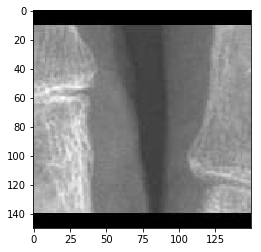

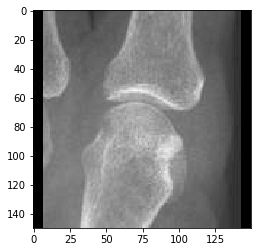

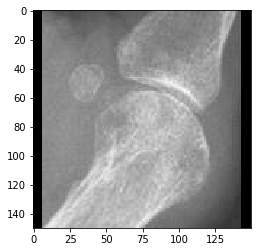

In [10]:
for i in range(3):    
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.show()

Safe image array, labels array and patients array to disk

In [11]:
with h5py.File('/data/joint_scoring/img_array.h5', 'w') as hf:
    hf.create_dataset("img_array",  data=images)
    
with h5py.File('/data/joint_scoring/lbl_array.h5', 'w') as hf:
    hf.create_dataset("lbl_array",  data=labels)
    
with h5py.File('/data/joint_scoring/pid_array.h5', 'w') as hf:
    hf.create_dataset("pid_array",  data=patients)

Read image array and labels from disk & change shape of images

In [24]:
with h5py.File('/data/joint_scoring/img_array.h5', 'r') as hf:
    images = hf['img_array'][:]
    
with h5py.File('/data/joint_scoring/lbl_array.h5', 'r') as hf:
    labels = hf['lbl_array'][:]
    
with h5py.File('/data/joint_scoring/pid_array.h5', 'r') as hf:
    patients = hf['pid_array'][:]

images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)

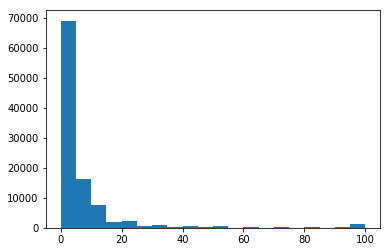

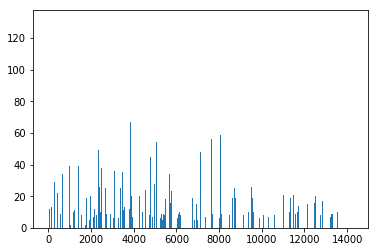

In [25]:
plt.hist(labels, bins=20)
plt.show()

pid_unique, pid_counts = np.unique(patients, return_counts = True)
plt.bar(pid_unique, pid_counts)
plt.show()

In [26]:
# create 5 classes (according to Rattingen classification)

# 0 -> joint is healthy
labels[(labels > 0) & (labels <= 20)] = 1 # -> one ore more erosions, <= 20 % of the joint surface is eroded
labels[(labels > 20) & (labels <= 40)] = 2 # -> 21 - 40 % of the joint surface is eroded
labels[(labels > 40) & (labels <= 60)] = 3 # -> 41 - 60 % of the joint surface is eroded
labels[(labels > 60) & (labels <= 80)] = 4 # -> 61 - 80 % of the joint surface is eroded
labels[labels > 80] = 5 # > 80 % of the joint surface is eroded

Create train / test / validation split
Stratified by class, but all images of the same patient have to stay together

In [27]:
img_train = []
labels_train = []
patients_train = []

img_test = []
labels_test = []
patients_test = []

img_val = []
labels_val = []
patients_val = []

indices = np.random.permutation(images.shape[0])
images = images[indices]
labels = labels[indices]
patients = patients[indices]

for i in range(labels.shape[0]):
    
    if (i % 100) == 0:
        clear_output()
        print("Creating test/train/validation split, {0:.2f} % finished".format(i/labels.shape[0]*100))
    
    if patients[i] in patients_train:
        img_train.append(images[i])
        labels_train.append(labels[i])
        patients_train.append(patients[i])
    elif patients[i] in patients_test:
        img_test.append(images[i])
        labels_test.append(labels[i])
        patients_test.append(patients[i])
    elif patients[i] in patients_val:
        img_val.append(images[i])
        labels_val.append(labels[i])
        patients_val.append(patients[i])
    else:
        choice = np.random.choice(a=3, p=[0.7, 0.2, 0.1])
        if choice == 0:
            img_train.append(images[i])
            labels_train.append(labels[i])
            patients_train.append(patients[i])
        elif choice == 1:
            img_test.append(images[i])
            labels_test.append(labels[i])
            patients_test.append(patients[i])
        else:
            img_val.append(images[i])
            labels_val.append(labels[i])
            patients_val.append(patients[i])      

Creating test/train/validation split, 99.94 % finished


In [28]:
img_train = np.array(img_train)
labels_train = np.array(labels_train)
patients_train = np.array(patients_train)

img_test = np.array(img_test)
labels_test = np.array(labels_test)
patients_test = np.array(patients_test)

img_val = np.array(img_val)
labels_val = np.array(labels_val)
patients_val = np.array(labels_val)

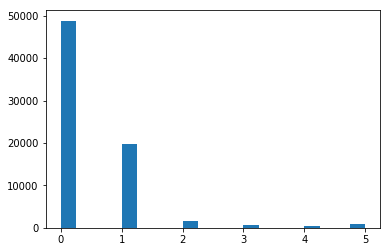

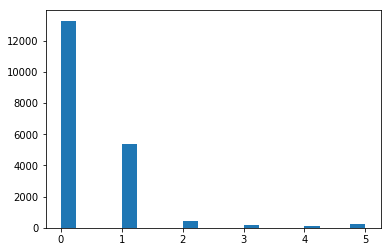

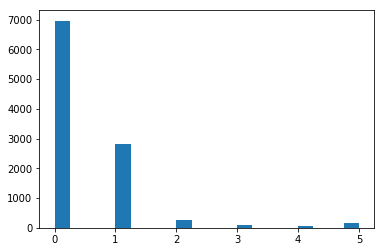

0.7069671930768102
0.19176648902361512
0.10126631789957463


In [29]:
plt.hist(labels_train, bins=20)
plt.show()

plt.hist(labels_test, bins=20)
plt.show()

plt.hist(labels_val, bins=20)
plt.show()

print(labels_train.shape[0] / (labels_train.shape[0] + labels_test.shape[0] + labels_val.shape[0] ))
print(labels_test.shape[0] / (labels_train.shape[0] + labels_test.shape[0] + labels_val.shape[0] ))
print(labels_val.shape[0] / (labels_train.shape[0] + labels_test.shape[0] + labels_val.shape[0] ))

In [ ]:
with h5py.File('/data/joint_scoring/img_train.h5', 'w') as hf:
    hf.create_dataset("img_train",  data=img_train)
with h5py.File('/data/joint_scoring/img_test.h5', 'w') as hf:
    hf.create_dataset("img_test",  data=img_test)
with h5py.File('/data/joint_scoring/img_val.h5', 'w') as hf:
    hf.create_dataset("img_val",  data=img_val)

with h5py.File('/data/joint_scoring/labels_train.h5', 'w') as hf:
    hf.create_dataset("labels_train",  data=labels_train)
with h5py.File('/data/joint_scoring/labels_test.h5', 'w') as hf:
    hf.create_dataset("labels_test",  data=labels_test)
with h5py.File('/data/joint_scoring/labels_val.h5', 'w') as hf:
    hf.create_dataset("labels_val",  data=labels_val)
    
with h5py.File('/data/joint_scoring/patients_train.h5', 'w') as hf:
    hf.create_dataset("patients_train",  data=patients_train)
with h5py.File('/data/joint_scoring/patients_test.h5', 'w') as hf:
    hf.create_dataset("patients_test",  data=patients_test)
with h5py.File('/data/joint_scoring/patients_val.h5', 'w') as hf:
    hf.create_dataset("patients_val",  data=patients_val)

In [9]:
with h5py.File('/data/joint_scoring/img_train.h5', 'r') as hf:
    img_train = hf['img_train'][:]
with h5py.File('/data/joint_scoring/img_test.h5', 'r') as hf:
    img_test = hf['img_test'][:]
with h5py.File('/data/joint_scoring/img_val.h5', 'r') as hf:
    img_val = hf['img_val'][:]
    
with h5py.File('/data/joint_scoring/labels_train.h5', 'r') as hf:
    labels_train = hf['labels_train'][:]
with h5py.File('/data/joint_scoring/labels_test.h5', 'r') as hf:
    labels_test = hf['labels_test'][:]
with h5py.File('/data/joint_scoring/labels_val.h5', 'r') as hf:
    labels_val = hf['labels_val'][:]

In [12]:
# one hot encode outputs
labels_train_onehot = LabelBinarizer().fit_transform(labels_train)
labels_test_onehot = LabelBinarizer().fit_transform(labels_test)
labels_val_onehot = LabelBinarizer().fit_transform(labels_val)
num_classes = labels_test_onehot.shape[1]
print(num_classes)

6


In [13]:
with h5py.File('/data/joint_scoring/labels_train_onehot.h5', 'w') as hf:
    hf.create_dataset("labels_train_onehot",  data=labels_train_onehot)
with h5py.File('/data/joint_scoring/labels_test_onehot.h5', 'w') as hf:
    hf.create_dataset("labels_test_onehot",  data=labels_test_onehot)
with h5py.File('/data/joint_scoring/labels_val_onehot.h5', 'w') as hf:
    hf.create_dataset("labels_val_onehot",  data=labels_val_onehot)

------------ Continue here ----------------------------------------------

Import numpy array and calculate class weights

In [3]:
with h5py.File('/data/joint_scoring/labels_train.h5', 'r') as hf:
    labels_train = hf['labels_train'][:]

# define class weights because of imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                 classes=np.unique(labels_train), 
                                                 y=labels_train)

print(max(weights)/min(weights))

weights = dict(enumerate(weights))
print(weights)

112.229885057
{0: 0.2468182438891165, 1: 0.61240428271328862, 2: 7.3563288563288562, 3: 15.980990274093722, 4: 27.700383141762451, 5: 12.358632478632479}


Import data as HDF5 Matrix

In [4]:
img_train = HDF5Matrix('/data/joint_scoring/img_train.h5', 'img_train')
img_test = HDF5Matrix('/data/joint_scoring/img_test.h5', 'img_test')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_onehot.h5', 'labels_train_onehot')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_onehot.h5', 'labels_test_onehot')

In [5]:
train_datagen = ImageDataGenerator(
        rotation_range=25,
        shear_range=0.2,
        zoom_range=0.2)

In [6]:
num_classes = 6

## 2. Model

In [7]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=num_classes, activation="softmax",
                    kernel_initializer="he_normal"))

    # Compile model
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [8]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [9]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [10]:
print(new_folder)

20171026_154934


In [11]:
desc = "model with data generator and class weights. Division by 255 moved from generator to first (lambda) layer of the model"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [12]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [13]:
model.fit_generator(generator=train_datagen.flow(img_train, labels_train, batch_size=32),
                    steps_per_epoch=len(img_train) / 32, 
                    epochs=20, verbose = 2, callbacks=[tb_callback], 
                    validation_data=(img_test, labels_test),
                    class_weight=weights)

Epoch 1/20
217s - loss: 1.9698 - acc: 0.1816 - val_loss: 1.3670 - val_acc: 0.3773
Epoch 2/20
208s - loss: 1.6896 - acc: 0.3716 - val_loss: 1.0308 - val_acc: 0.6032
Epoch 3/20
208s - loss: 1.5999 - acc: 0.4589 - val_loss: 0.8780 - val_acc: 0.6441
Epoch 4/20
208s - loss: 1.5680 - acc: 0.4885 - val_loss: 0.8112 - val_acc: 0.6647
Epoch 5/20
207s - loss: 1.5407 - acc: 0.5081 - val_loss: 1.0107 - val_acc: 0.6112
Epoch 6/20
208s - loss: 1.4940 - acc: 0.5099 - val_loss: 1.0467 - val_acc: 0.5951
Epoch 7/20
208s - loss: 1.4735 - acc: 0.5259 - val_loss: 0.9823 - val_acc: 0.6119
Epoch 8/20
207s - loss: 1.4474 - acc: 0.5347 - val_loss: 0.8749 - val_acc: 0.6518
Epoch 9/20
208s - loss: 1.4343 - acc: 0.5388 - val_loss: 1.0671 - val_acc: 0.5654
Epoch 10/20
208s - loss: 1.4127 - acc: 0.5541 - val_loss: 0.7858 - val_acc: 0.6807
Epoch 11/20
207s - loss: 1.3909 - acc: 0.5599 - val_loss: 0.8495 - val_acc: 0.6674
Epoch 12/20
208s - loss: 1.3866 - acc: 0.5647 - val_loss: 0.8912 - val_acc: 0.6294
Epoch 13/20
2

KeyboardInterrupt: 

In [14]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print("Error: %.2f%%" % (100 - scores[1] * 100))

Error: 32.00%


In [15]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict_classes(img_test)
p = model.predict_proba(img_test)

print(classification_report(np.argmax(labels_test, axis=1), pred))
cnf_matrix = confusion_matrix(np.argmax(labels_test, axis=1), pred)
print(cnf_matrix)

19611/19611 [==============================] - 14s    
             precision    recall  f1-score   support

          0       0.75      0.92      0.82     13286
          1       0.48      0.17      0.25      5369
          2       0.16      0.28      0.21       423
          3       0.11      0.07      0.09       177
          4       0.08      0.21      0.11        98
          5       0.35      0.43      0.39       258

avg / total       0.65      0.68      0.64     19611

[[12174   785   141    29    56   101]
 [ 3987   895   330    37    62    58]
 [  112   118   120    15    39    19]
 [   17    30    74    13    30    13]
 [    9     9    27    13    21    19]
 [   18    17    38     8    65   112]]


Confusion matrix, without normalization
[[12174   785   141    29    56   101]
 [ 3987   895   330    37    62    58]
 [  112   118   120    15    39    19]
 [   17    30    74    13    30    13]
 [    9     9    27    13    21    19]
 [   18    17    38     8    65   112]]
Normalized confusion matrix
[[ 0.91630288  0.05908475  0.01061267  0.00218275  0.00421496  0.00760199]
 [ 0.74259639  0.16669771  0.06146396  0.00689141  0.01154777  0.01080276]
 [ 0.26477541  0.27895981  0.28368794  0.03546099  0.09219858  0.04491726]
 [ 0.0960452   0.16949153  0.4180791   0.07344633  0.16949153  0.07344633]
 [ 0.09183673  0.09183673  0.2755102   0.13265306  0.21428571  0.19387755]
 [ 0.06976744  0.06589147  0.14728682  0.03100775  0.25193798  0.43410853]]


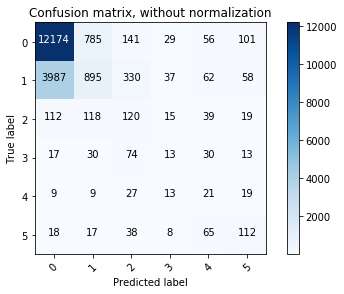

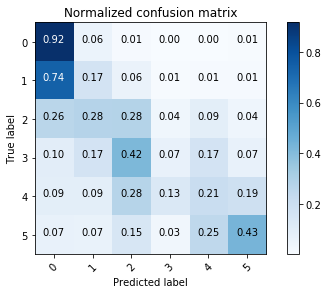

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [18]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)